In [1]:
from functions import *
from models import *

2024-10-18 11:02:04.562867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 11:02:04.584453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 11:02:04.591055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 11:02:04.607713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 11:02:05.584977: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Load rivers

In [3]:
import fiona
import geopandas as gpd
from shapely.geometry import shape
source_folder = '../data/external/raster_masks'
rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        #rius = list(img_per_river.keys())
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r
rivers.keys()

dict_keys(['Jorenbach', 'Seltenbach', 'Plattenbach', 'Riale_di_Motom', 'Ruisseau_des_Frassy', 'Kasperabach', 'Rausenbach', 'Rotenbachli', 'Ruisseau_de_Chatillon', 'Eibachli', 'Chrauchbach', 'Fiume_Peccia', 'Emme', 'LaVenoge_shapefile', 'Leiterbergbach', 'Stossbach', 'Torrent_de_Greffe', 'Tschagibach', 'Wasserfallenbach', 'La_Saufla', 'Guuhetbach', 'Schusselbach', 'LaBroye_shapefile', 'Usser_Bargelbach', 'La_Paudeze', 'Zauggenbach', 'Bisse-Neuf', 'Ragn_da_Colm', 'Calcascia', 'Raptgusa', 'swissTLMboiron', 'Guetentalbach', 'Tschermanner_Bach', 'Susasca', 'Riale_della_Fontana', 'Haagbach', 'Ri_dei_Calcestri', 'Maira_|_Mera', 'Ruisseau_de_la_Leyvra', 'Alplibach', 'Malbunbach', 'Aletenbach', 'I_Custiell', 'Bruederbach', 'Spitzalpelibach', 'Wiesenbach', 'El_Ri_Vall_Mala', 'Ruisseau_de_Pra_Gouma', 'Ruisseau_du_Perelet', 'le_boiron2', 'Ri_di_Piera'])

### Choose inputs

In [207]:
W = 256
filter_river = None#[3,11,12]
inputs = None#['ndvi','discharge', 'slope']
conditioned = False
batch_size = 4
epochs = 10
model_name = "img_wise_CNN" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img

In [208]:
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)
       
all_dir_paths    

{'lst': ['../data/preprocessed/lst/Hindereggbachli',
  '../data/preprocessed/lst/Plattenbach',
  '../data/preprocessed/lst/Rausenbach',
  '../data/preprocessed/lst/Riale_della_Valle',
  '../data/preprocessed/lst/Malbunbach',
  '../data/preprocessed/lst/Seltenbach',
  '../data/preprocessed/lst/Ruisseau_des_Frassy',
  '../data/preprocessed/lst/Rotenbachli',
  '../data/preprocessed/lst/Ruisseau_de_Pra_Gouma',
  '../data/preprocessed/lst/Torrent_de_Greffe',
  '../data/preprocessed/lst/Guuhetbach',
  '../data/preprocessed/lst/LaBroye_shapefile',
  '../data/preprocessed/lst/Harmedingebachli',
  '../data/preprocessed/lst/Hindertoss',
  '../data/preprocessed/lst/Ragn_da_Colm',
  '../data/preprocessed/lst/Raptgusa',
  '../data/preprocessed/lst/Alplibach',
  '../data/preprocessed/lst/La_Paudeze',
  '../data/preprocessed/lst/Bisse_de_Marais',
  '../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/Ramserlibachli',
  '../data/preprocessed/lst/Ri_dei_Calcestri',
  '../data/prep

In [209]:
sets = [set([path.split('/')[-1] for path in paths]) for paths in all_dir_paths.values()]

from collections import Counter
rr = Counter()
for sett in sets:
    for r in sett:
        rr[r]+=1

common_rivers = set([key for key, count in rr.items() if count >= 5])
# Crear un nuevo diccionario con solo los ríos comunes
filtered_data_paths = {}
for key, paths in all_dir_paths.items():
    # Filtrar las rutas que pertenecen a los common_rivers
    if key!= 'masked':
        filtered_paths = [path for path in paths if path.split('/')[-1] in common_rivers]
    else: 
        filtered_paths = [path for path in paths if path.split('/')[-2] in common_rivers]
    filtered_data_paths[key] = filtered_paths

for kk, vv in filtered_data_paths.items():
    print(kk,len(vv))

lst 26
ndvi 26
wt 26
masked 26
discharge 26
slope 26


In [210]:
all_dir_paths = filtered_data_paths

In [211]:
total_data = {}
total_times = {}
complete_rivers = []
for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'discharge' and k != 'slope':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)

            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data, times = load_data(v,W,list_rgb)
        
        filtered = [arr for arr in data.values() if arr.size > 0]

        total_data[k] = np.concatenate(filtered, axis=0)
        total_times[k] = times
        print(k,':' ,total_data[k].shape)

    elif k == 'discharge' or k == 'slope':
        total = []
        for p in v:
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                r,m = load_raster(file_path, False)
                var = resize_image(r, W,W)
                img_river = labels.count(p.split("/")[-1])
                var_input = np.tile(var, (img_river, 1, 1))
                total.append(var_input)
        
        total_data[k] = np.concatenate(total, axis=0)
        print(k,':' ,total_data[k].shape)


lst : (204, 256, 256, 3)
ndvi : (204, 256, 256)
wt : (204, 256, 256)
masked : (204, 256, 256, 3)
discharge : (204, 256, 256)
slope : (204, 256, 256)


In [212]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
river_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1))
# Mostrar el array resultante
print(river_encoded.shape)

(204, 22)


In [213]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (204, 256, 256, 3) (204, 256, 256)
targets shape: (204, 256, 256)


In [214]:
'''for i in range(lst.shape[0]):
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))
    axes[0].set_title('lst')

    axes[1].imshow(ndvi[i])
    axes[1].set_title('ndvi')

    axes[2].imshow(data_targets[i])
    axes[2].set_title('wt')

    if total_times['lst'][0][i] != total_times['ndvi'][0][i] or total_times['lst'][0][i] != total_times['wt'][0][i] or total_times['ndvi'][0][i] != total_times['wt'][0][i]:
        print('Time mismatch')

    plt.suptitle(f"For time {total_times['lst'][0][0]}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
'''

'for i in range(lst.shape[0]):\n    fig, axes = plt.subplots(1,3, figsize=(10,5))\n    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))\n    axes[0].set_title(\'lst\')\n\n    axes[1].imshow(ndvi[i])\n    axes[1].set_title(\'ndvi\')\n\n    axes[2].imshow(data_targets[i])\n    axes[2].set_title(\'wt\')\n\n    if total_times[\'lst\'][0][i] != total_times[\'ndvi\'][0][i] or total_times[\'lst\'][0][i] != total_times[\'wt\'][0][i] or total_times[\'ndvi\'][0][i] != total_times[\'wt\'][0][i]:\n        print(\'Time mismatch\')\n\n    plt.suptitle(f"For time {total_times[\'lst\'][0][0]}", fontsize=16)\n    plt.tight_layout()\n    plt.subplots_adjust(top=0.9)\n    plt.show()\n'

Convert inputs to gray images

'''masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)'''

Split data

In [215]:
if inputs != None:
    inputs_d = [total_data[inp] for inp in inputs]#[ndvi,discharge,slope] 

In [216]:
if inputs == None:
    train_index, validation_index, test_index = split_data(lst, data_targets)
    input_data = lst
else:
    # Lista de diferentes conjuntos de imágenes a combinar con LST
    additional_images = inputs_d # Añade todas las imágenes adicionales que quieras

    # Expande la dimensión de cada conjunto de imágenes para asegurar que tengan un canal extra
    expanded_images = [np.expand_dims(img, axis=-1) for img in additional_images]  # Cada imagen tendrá shape: (n_samples, 256, 256, 1)

    # Concatenar LST con todas las imágenes adicionales a lo largo del último eje (canales)
    combined_input = np.concatenate([lst] + expanded_images, axis=-1)  # LST (RGB) + todas las imágenes adicionales
    train_index, validation_index, test_index = split_data(combined_input, data_targets)
    input_data = combined_input
    

validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index, :]
validation_rivers = river_encoded[validation_index, :]

test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index, :]
test_rivers = river_encoded[test_index, :]

train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index, :]
train_rivers = river_encoded[train_index, :]



In [217]:
print(train_input.shape, train_target.shape, validation_input.shape, validation_target.shape, test_input.shape, test_target.shape, train_rivers.shape, validation_rivers.shape, test_rivers.shape)

(164, 256, 256, 6) (164, 256, 256) (20, 256, 256, 6) (20, 256, 256) (20, 256, 256, 6) (20, 256, 256) (164, 22) (20, 22) (20, 22)


## CNN simpler

#### Choose model

In [218]:
# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset

In [220]:
if conditioned:
    input_args = (input_shape, river_encoded.shape[1])
    model_input = [train_input, train_rivers]
    val_model_input = [validation_input, validation_rivers]
    test_model_input = [test_input, test_rivers]
else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input

if model_name == "img_wise_CNN":
    if conditioned:
        model = build_simplified_cnn_model_label(input_args[0], input_args[1])
    else:
        model = build_simplified_cnn_model(input_args)
elif model_name == 'CNN':
    model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    train_input = train_input[:,:,:,:3]
    validation_input = validation_input[:,:,:,:3]
    test_input =  train_input[:,:,:,:3]
    input_args = (W,W,3)
    model =  build_transfer_model(input_args)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 65536)          │    16,842,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 256, 256)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,946,304 (152.38 MB)

 Trainable params: 25,231,616 (96.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

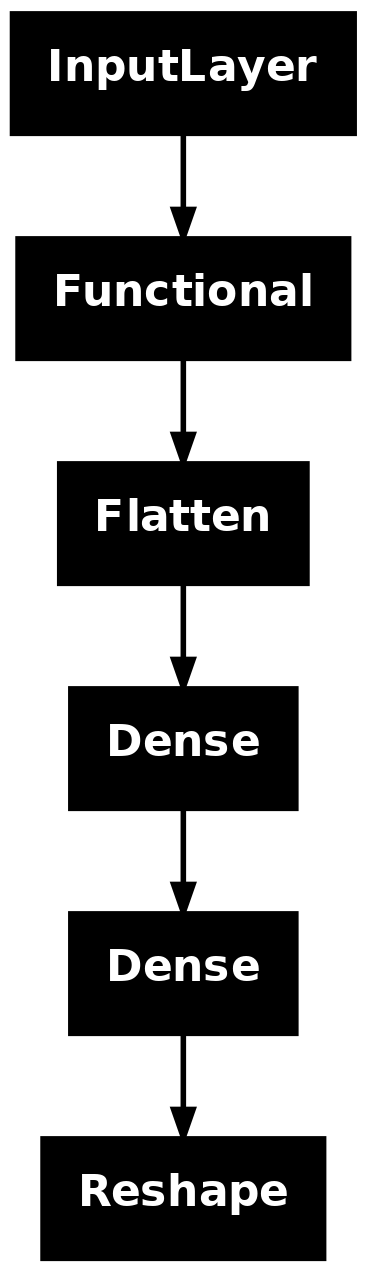

In [221]:
tf.keras.utils.plot_model(model)

In [222]:
#history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))
history = model.fit(model_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_model_input, validation_target))

Epoch 1/10


ValueError: Input 0 of layer "functional_31" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(4, 256, 256, 6)

In [ ]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.savefig('../plots/cnn.png')

In [ ]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [ ]:
validation_prediction = model.predict(val_model_input)
test_prediction = model.predict(test_model_input)
results = {'MAE':0,'MSE':0,'RMSE':0,'R²':0,'MAPE (%)':0,'MSE sample-wise':0}

Image wise metrics results

In [ ]:
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    # Flatten the true and predicted values for this sample
    riv = rivers[labels[test_index[i]]].flatten()
    
    y_true_flatten = test_target[i].flatten()
    y_true_mask = y_true_flatten[riv != 0]

    y_pred_flatten = test_prediction[i].flatten()
    y_pred_mask = y_pred_flatten[riv != 0]

    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

See what are the areas with more prediction error

In [ ]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

In [ ]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [ ]:
laabeel = 'label' if conditioned else 'no label'
var_inputs = '' if inputs == None else '_'.join(inputs)
variables = 'lst, '+var_inputs+', ' + laabeel


In [ ]:
details = {'RMSE':mean_results['RMSE'],'Variables':variables,'Input': f'{len(np.unique(labels))} rivers', 'Output': 'wt', 'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')

In [ ]:
pd.read_excel(f'../results/{model_name}_results.xlsx')